<a href="https://colab.research.google.com/github/AnnaK8090/CIND-820_Big-Data-Analytics-Project/blob/main/3_Collaborative_Filtering_Itemr_Based_CF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Item-based collaborative filtering algorythm:**

Item-based collaborative filtering makes recommendations based on user-product interactions in the past. The method looks for similar items based on the items users have already liked or positively interacted with. It was developed by Amazon in 1998 and plays a great role in Amazon’s success.

The algorithm suggests an item based on items the user has previously consumed. 
It looks for the items the user has consumed then it finds other items similar to consumed items and recommends accordingly.


In [1]:
# 1. Importing libraries:
import numpy as np 
import pandas as pd      
import scipy.stats
import seaborn as sns
# Similarity
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
# 2. Loading csv file and saving it into a dataframe:
masterDF = pd.read_csv('MasterDF.csv', on_bad_lines='skip')

In [3]:
masterDF.shape

(113210, 40)

In [4]:
# 3. Since order_ID (~ transaction id) might have more than 1 review it makes sense to aggregate dataframe by order_id and choose max review score:
#masterDF_grouped = masterDF.groupby(['order_id','customer_unique_id','product_id','product_category_name_english'])['review_score'].max()
masterDF_grouped = masterDF.groupby(['customer_unique_id','product_id'])['review_score'].max()
masterDF_grouped = masterDF_grouped.reset_index()
masterDF_grouped.shape

(97689, 3)

In [5]:
masterDF_grouped.to_csv ('MasterDF_grouped.csv', index = None, header=True)

In [6]:
masterDF_grouped.head()

,customer_unique_id,product_id,review_score
0,0000366f3b9a7992bf8c76cfdf3221e2,372645c7439f9661fbbacfd129aa92ec,5
1,0000b849f77a49e4a4ce2b2a4ca5be3f,5099f7000472b634fea8304448d20825,4
2,0000f46a3911fa3c0805444483337064,64b488de448a5324c4134ea39c28a34b,3
3,0000f6ccb0745a6a4b88665a16c9f078,2345a354a6f2033609bbf62bf5be9ef6,4
4,0004aac84e0df4da2b147fca70cf8255,c72e18b3fe2739b8d24ebf3102450f37,5


In [7]:
masterDF_grouped['review_score'] = masterDF_grouped['review_score'].astype(float)

In [8]:
masterDF_grouped.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97689 entries, 0 to 97688
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   customer_unique_id  97689 non-null  object 
 1   product_id          97689 non-null  object 
 2   review_score        97689 non-null  float64
dtypes: float64(1), object(2)
memory usage: 2.2+ MB


In [9]:
# 3. Descriptive statistics:
# Number of users
print('The dataset has', masterDF_grouped['customer_unique_id'].nunique(), 'unique users')
# Number of movies
print('The ratings dataset has', masterDF_grouped['product_id'].nunique(), 'unique products')
# Number of ratings
print('The ratings dataset has', masterDF_grouped['review_score'].nunique(), 'unique ratings')
# List of unique ratings
print('The unique ratings are', sorted(masterDF_grouped['review_score'].unique()))

The dataset has 91481 unique users
The ratings dataset has 31481 unique products
The ratings dataset has 5 unique ratings
The unique ratings are [1.0, 2.0, 3.0, 4.0, 5.0]


In [22]:
# 4. We need to filter the products and keep only those with over 100 reviews for the analysis. This is to make the calculation manageable by the Google Colab memory.
# To do that, we first group products by product_id, count the number of reviews, and keep only the products with greater than 50 reviews.
# The average reviews for the products are calculated as well.

# Aggregate by product
agg_reviews = masterDF_grouped.groupby('product_id').agg(mean_rating = ('review_score', 'mean'), number_of_reviews = ('review_score', 'count')).reset_index()
# Keep the products with over 50 ratings
agg_reviews_GT100 = agg_reviews[agg_reviews['number_of_reviews']>100]
agg_reviews_GT100.shape

(47, 3)

In [23]:
# 5. Check popular products
agg_reviews_GT100.sort_values(by='number_of_reviews', ascending=False).head()

,product_id,mean_rating,number_of_reviews
18858,99a4788cb24856965c36a24e339b6058,3.941964,448
21139,aca2eb7d00ea1a7b8ebd4e68314663af,4.127962,422
8230,422879e10f46682990de24d770e7f83d,4.143678,348
25842,d1c427060a0f73f6b889a5c7c61f2ac4,4.325806,310
7036,389d119b48cf3043d311335e499d9c6b,4.208469,307


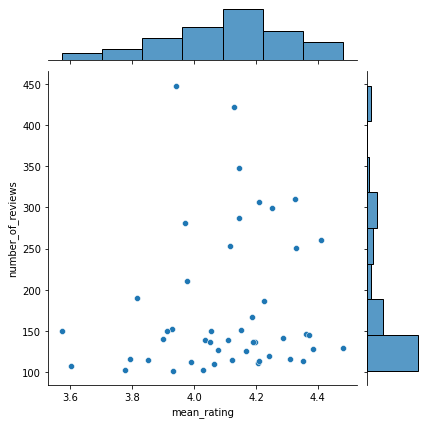

In [24]:
# 6. # Let’s use a jointplot to check the correlation between the average rating and the number of reviews.
# We can see somewhat an upward trend from the scatter plot, showing that popular products get higher ratings. 
# The number of reviews distribution shows that most products have less than 150 reviews.

sns.jointplot(x='mean_rating', y='number_of_reviews', data=agg_reviews_GT100)


In [25]:
# To keep only the 47 products with more than 100 ratings, we need to join the product with the user-rating level dataframe.
# how='inner' and on='product_id' ensure that only the products with more than 100 reviews are included.

# Merge data
df_GT100 = pd.merge(masterDF_grouped, agg_reviews_GT100[['product_id']], on='product_id', how='inner')
df_GT100.head()

,customer_unique_id,product_id,review_score
0,001ae5a1788703d64536c30362503e49,c4baedd846ed09b85f78a781b522f126,5.0
1,011785063c56f2c239064f603bf02a05,c4baedd846ed09b85f78a781b522f126,5.0
2,01d4d353f424ed250bf892af49d30abe,c4baedd846ed09b85f78a781b522f126,5.0
3,02359eb55cd801c825452c46c59d416f,c4baedd846ed09b85f78a781b522f126,4.0
4,0c93af7b12937811013ec6514d609ddb,c4baedd846ed09b85f78a781b522f126,3.0


In [26]:
# Number of users
print('The ratings dataset has', df_GT100['customer_unique_id'].nunique(), 'unique customers')
# Number of movies
print('The ratings dataset has', df_GT100['product_id'].nunique(), 'unique products')
# Number of ratings
print('The ratings dataset has', df_GT100['review_score'].nunique(), 'unique reviews')
# List of unique ratings
print('The unique reviews are', sorted(df_GT100['review_score'].unique()))


The ratings dataset has 8140 unique customers
The ratings dataset has 47 unique products
The ratings dataset has 5 unique reviews
The unique reviews are [1.0, 2.0, 3.0, 4.0, 5.0]


In [55]:
# After filtering the products with over 100 reviews, we have 8140 users that rated 47 products.

In [27]:
# We will transform the dataset into a matrix format. The rows of the matrix are users, and the columns of the matrix are products. 
# The value of the matrix is the user rating of the product if there is a rating. Otherwise, it shows ‘NaN’.

# Create user-item matrix
matrix = df_GT100.pivot_table(index='customer_unique_id', columns='product_id', values='review_score')
matrix.head()

product_id,06edb72f1e0c64b14c5b79353f7abea3,0aabfb375647d9738ad0f7b4ea3653b1,154e7e31ebfa092203795c972e5804a6,165f86fe8b799a708a20ee4ba125c289,19c91ef95d509ea33eda93495c4d3481,2028bf1b01cafb2d2b1901fca4083222,2b4609f8948be18874494203496bc318,35afc973633aaeb6b877ff57b2793310,368c6c730842d78016ad823897a372db,36f60d45225e60c7da4558b070ce4b60,...,c4baedd846ed09b85f78a781b522f126,c6dd917a0be2a704582055949915ab32,d017a2151d543a9885604dc62a3d9dcc,d1c427060a0f73f6b889a5c7c61f2ac4,d285360f29ac7fd97640bf0baef03de0,e0cf79767c5b016251fe139915c59a26,e0d64dcfaa3b6db5c54ca298ae101d05,e53e557d5a159f5aa2c5e995dfdf244b,ec2d43cc59763ec91694573b31f1c29a,f1c7f353075ce59d8a6f3cf58f419c9c
customer_unique_id,,,,,,,,,,,,,,,,,,,,,
001ae5a1788703d64536c30362503e49,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
002ae492472e45ad6ebeb7a625409392,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
002bdeb33da5b1b3ce8b9c822f749c82,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
002feefec5af0a3b26ee7839c66d205e,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0050dcff37f8b9ff611d245e30572b46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [32]:
# Identify Similar Items
# There are different ways to measure similarities. Pearson correlation and cosine similarity are two widely used methods.
# We will calculate the item similarity matrix using Pearson correlation.

# User similarity matrix using Pearson correlation
item_similarity = matrix.corr()
item_similarity.head()

product_id,06edb72f1e0c64b14c5b79353f7abea3,0aabfb375647d9738ad0f7b4ea3653b1,154e7e31ebfa092203795c972e5804a6,165f86fe8b799a708a20ee4ba125c289,19c91ef95d509ea33eda93495c4d3481,2028bf1b01cafb2d2b1901fca4083222,2b4609f8948be18874494203496bc318,35afc973633aaeb6b877ff57b2793310,368c6c730842d78016ad823897a372db,36f60d45225e60c7da4558b070ce4b60,...,c4baedd846ed09b85f78a781b522f126,c6dd917a0be2a704582055949915ab32,d017a2151d543a9885604dc62a3d9dcc,d1c427060a0f73f6b889a5c7c61f2ac4,d285360f29ac7fd97640bf0baef03de0,e0cf79767c5b016251fe139915c59a26,e0d64dcfaa3b6db5c54ca298ae101d05,e53e557d5a159f5aa2c5e995dfdf244b,ec2d43cc59763ec91694573b31f1c29a,f1c7f353075ce59d8a6f3cf58f419c9c
product_id,,,,,,,,,,,,,,,,,,,,,
06edb72f1e0c64b14c5b79353f7abea3,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0aabfb375647d9738ad0f7b4ea3653b1,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
154e7e31ebfa092203795c972e5804a6,NaN,NaN,1.0,NaN,NaN,NaN,0.938725,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
165f86fe8b799a708a20ee4ba125c289,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19c91ef95d509ea33eda93495c4d3481,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [33]:
# Now let’s use a specific product as an example to illustrate how to find similar items.
# We first need to exclude 1 item from the similar items list and decide the number of similar items.

# Pick an item ID
picked_item='154e7e31ebfa092203795c972e5804a6'
# Remove picked item ID from the candidate list
item_similarity.drop(index=picked_item, inplace=True)
# Take a look at the data
item_similarity.head()

product_id,06edb72f1e0c64b14c5b79353f7abea3,0aabfb375647d9738ad0f7b4ea3653b1,154e7e31ebfa092203795c972e5804a6,165f86fe8b799a708a20ee4ba125c289,19c91ef95d509ea33eda93495c4d3481,2028bf1b01cafb2d2b1901fca4083222,2b4609f8948be18874494203496bc318,35afc973633aaeb6b877ff57b2793310,368c6c730842d78016ad823897a372db,36f60d45225e60c7da4558b070ce4b60,...,c4baedd846ed09b85f78a781b522f126,c6dd917a0be2a704582055949915ab32,d017a2151d543a9885604dc62a3d9dcc,d1c427060a0f73f6b889a5c7c61f2ac4,d285360f29ac7fd97640bf0baef03de0,e0cf79767c5b016251fe139915c59a26,e0d64dcfaa3b6db5c54ca298ae101d05,e53e557d5a159f5aa2c5e995dfdf244b,ec2d43cc59763ec91694573b31f1c29a,f1c7f353075ce59d8a6f3cf58f419c9c
product_id,,,,,,,,,,,,,,,,,,,,,
06edb72f1e0c64b14c5b79353f7abea3,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0aabfb375647d9738ad0f7b4ea3653b1,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
165f86fe8b799a708a20ee4ba125c289,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19c91ef95d509ea33eda93495c4d3481,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2028bf1b01cafb2d2b1901fca4083222,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [35]:
# Number of similar items
n = 100
# item similarity threashold
user_similarity_threshold = 0.05
# Get top n similar item
similar_items = item_similarity[item_similarity[picked_item]>user_similarity_threshold][picked_item].sort_values(ascending=False)[:n]
# Print out top n similar items
print(f'The similar product for product {picked_item} are', similar_items)


The similar product for product 154e7e31ebfa092203795c972e5804a6 are product_id
7c1bd920dbdf22470b68bde975dd3ccf    0.970319
2b4609f8948be18874494203496bc318    0.938725
Name: 154e7e31ebfa092203795c972e5804a6, dtype: float64
